In [1]:
# Loading 
import glob 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, hilbert, chirp
from itertools import islice 
from matplotlib.font_manager import FontProperties

In [2]:
class filtering():
    def __init__(self, bsWn=[49, 51], hpWn=1, lpWn = 500,fs=2000):
        self.bandstopWn = bsWn
        self.highpassWn= hpWn
        self.lowpassWn = lpWn 
        self.fs=fs
        
    def downsample(self,data,proportion=0.4):
        return pd.Series(islice(data,0,len(data), int(1/proportion)))
    
    def highpass(self,data):
        b, a = signal.butter(5, self.highpassWn, 'highpass',fs = self.fs) 
        outputSignal = signal.filtfilt(b, a, data)
        return outputSignal

    def lowpass(self,data):
        b, a = signal.butter(4, self.lowpassWn, 'lowpass', fs = self.fs)
        y = lfilter(b, a, data)
        return y
    
    def bandstop(self,data):
        b, a = signal.butter(4, self.bandstopWn, 'bandstop',fs = self.fs)
        outputSignal = signal.filtfilt(b, a, data)
        return outputSignal 
        
    def rectify(self, to_rectify):
        return abs(to_rectify)    
    
    def cutofftail(self,data, obsCutOffSec=10):
         return data[:-obsCutOffSec * self.fs]
    
    def ADC(self, data):
        return 3.3/8191*data

In [7]:
class processing():
    def TKEO(self, data):
        TKEOData=data
        TKEOData[1:-1] = data[1:-1]**2 - data[:-2]*data[2:]
        return TKEOData
    
    def TKEThreshold(self,data, j=8):
        # 0.03 V ish for background 
        mu_data = np.mean(data[abs(data)<0.03])
        std_data = np.std(data[abs(data)<0.03])
        self.TH =  mu_data + std_data * j  
        return mu_data + std_data * j  
    
    def detectMovements(self,TKEOEMG, j=8, raw=False):
        suggestedContraction=TKEOEMG> self.TKEThreshold(TKEOEMG,j)
        trueIdx=[i for i, x in enumerate(suggestedContraction) if x]
        distPeak=np.array(trueIdx[1:])-np.array(trueIdx[:-1])
        if raw == False:
            for i in range(len(distPeak)): 
                if distPeak[i]<20000:
                    suggestedContraction[trueIdx[i]: trueIdx[i+1]] = True
        else:
            suggestedContraction = TKEOEMG>TKOE_treshold(TKEOEMG)
        
        return suggestedContraction
        

In [69]:
# path to EMG csv
paths = glob.glob("/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/MVCdata/OrderedFiles/PD_data/*.csv")

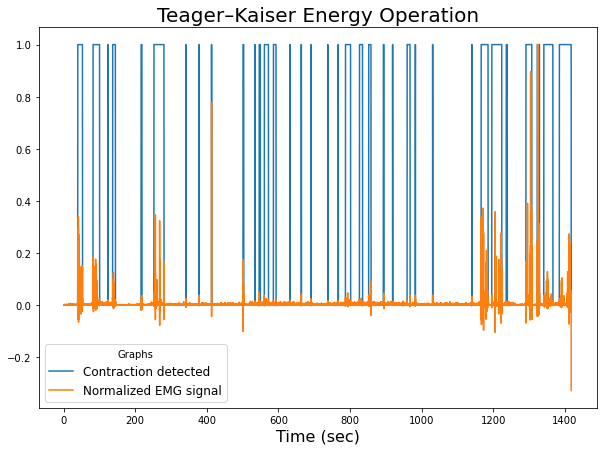

In [71]:
# select the file to load 
data_X = pd.read_csv(paths[1])

# extracting only EMG signal
data_X.columns =['time','EMG','batt','gX','gY','gZ','aX','aY','aZ']
EMGSignal = data_X['EMG'] 
EMGFilter = filtering()

# preprocessing
out1 = EMGFilter.bandstop(EMGFilter.ADC(EMGSignal)) 
out2 = EMGFilter.highpass(out1)
out3 = EMGFilter.lowpass(out2)
filteredEMG = EMGFilter.cutofftail(out3,obsCutOffSec=10)

# calculating EMG in Teager-Kaiser domain
# transform into TKE domain 
TKOE = processing().TKEO
TKEOEMG = TKOE(filteredEMG) 
# based detection of movements
detectMovements = TKOE = processing().detectMovements
suggestedContraction=detectMovements(TKEOEMG)


## Visualization
fig = plt.figure(figsize=(10,7))
time = np.arange(1, len(suggestedContraction)/(2000)+1, 1/2000)
font = FontProperties()
font.set_family('lmodern')
font.set_style('italic')
plt.plot(time,suggestedContraction, label = "Contraction detected")
plt.plot(time,filteredEMG/np.max(filteredEMG),label = 'Normalized EMG signal')
plt.legend(title = "Graphs",fontsize=12)
plt.xlabel('Time (sec)',fontsize=16)
plt.title("Teager–Kaiser Energy Operation",fontsize=20)
plt.show()  
#plt.savefig('TeagerKaiser.png')